# Introduction

The applications of brain tumour classification can be mainly divided into two categories:
- Classification of brain images into normal and abnormal classes, i.e. whether the brain images contain tumours or not. 
- Classification within abnormal brain images, in other words, discrimination between different types of brain tumours.

We are in the second case here, which is generally a relatively hard and challenging problem compared with binary classification (normal and abnormal). The important of this study is also contain by the fact of some tumors can be benign, there are extrinsic cerebral tumors that do not infiltrate surrounding parenchyma, compare to others, that are malignant, intrinsic cerebral tumors that may cause tumor-infiltrative edema.

Moreover, conventional diagnoses of brain tumor images are made by human interpretation, which heavily relies on the experience of radiologists who review and analyze the characteristics of the images. Consequently, interobserver and intraobserver variability are inevitable. That's why computer-aided diagnosis system can be very interesting to reduce the number of errors and help the diagnostic decision.

This brain tumor dataset containing 3064 images from 233 patients with three kinds of brain tumor: meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices). The original data can be found following this link: [figshare-brain-tumor-detection](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427).

The objective of this project is to build a classifier to classify each type of tumor.

In [4]:
# Imports
import random
import zipfile
import io
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sb

import tensorflow as tf

In [15]:
# Constants
IMAGE_SHAPE = (512, 512)

LABELS_NAME = {
    1 : "Meningioma",
    2 : "Glioma",
    3 : "Pituitary"
}

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [20]:
def show_image(images: np.ndarray, labels: np.ndarray, border: list, names: dict=LABELS_NAME) -> None:
    """Take the a random image and plot it, with as title the class label of the image. Add
    also the border of the tumor.

    Args:
        images (ndarray):
        labels (ndarray):
        border (list):
        names (dict):
            Defaults to LABELS_NAME.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Get the delimitation tumor
    obj = border[idx]

    # Get x and y axis
    x_axis = obj[0, 1::2]
    y_axis = obj[0, ::2]
    
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx], cmap='gray')
    plt.plot(x_axis, y_axis, ls='--', c='y', lw=3)
    plt.title(f"Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()
    
def predict_image(images: np.ndarray, labels: np.ndarray, prediction: np.ndarray) -> None:
    """Take the a random image and plot it, with as title the predicted value 
    of the image.

    Args:
        images (ndarray):
        labels (ndarray):
        prediction (ndarray):
    """
    # Get a random index
    idx = random.randint(0, len(images))
                   
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx],  cmap='gray')
    plt.title(f"True class: {labels[idx]} \n Predicted class: {prediction[idx]}")
    plt.axis('off')
    plt.show()

def map_image(image: np.ndarray, label: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Cast image type to float32 and normalize it.

    Args:
        image (ndarray): The array of images.
        label (ndarray): The array of labels

    Returns:
        ndarray: The array of images casted and normalized.
        ndarray: The unchanged array of labels.
    """
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    return image, label

## Data loading

In [7]:
# Define a list to store the image, label, and border arrays 
image_list, label_list, border_list  = [[] for _ in range(3)]
# Define the list of zip files
zip_folders = [folder for folder in os.listdir('./data/') if folder.endswith('.zip')]

for folder in zip_folders: 
    # Read zip file (without unzip it)
    with zipfile.ZipFile(os.path.join('data', folder), 'r') as zip_ref:
        # Get the list of .mat file in the zip folder
        mat_files = zip_ref.namelist()

        # Get the number of images
        num_files = len(mat_files)
        
        # Make a for loop
        for image in mat_files:
            # Open the first file in the zip folder
            with zip_ref.open(image) as image_bytes:
                
                # Load the .mat file using h5py
                with h5py.File(io.BytesIO(image_bytes.read()), 'r') as image_h5:
                    
                    # Get a dictionary of all the data in the file structure
                    data = image_h5['cjdata']

                    # Get the image, label and border and save in h5 object
                    data_img = data['image']
                    data_label = data['label']
                    data_broder = data['tumorBorder']

                    # Store h5 content in numpy arrays
                    img = np.array(data_img[:], dtype=np.uint8)
                    label = np.array(data_label[:], dtype=np.uint8)
                    border = np.array(data_broder[:], dtype=np.float32)

                    # Resize the img to a standard size
                    img_resized = cv2.resize(img, IMAGE_SHAPE)

                    # Append arrays to storage list
                    image_list.append(img_resized)
                    label_list.append(label)
                    border_list.append(border)

# Assertion on list length
assert len(image_list) == len(label_list) == len(border_list)

In [8]:
# Concatenate the list of images into a single numpy array
images = np.stack(image_list)
# Convert the labels list to a numpy array
labels = np.array(label_list).reshape(-1)

print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: (3064, 512, 512)
Label shape: (3064,)


## Exploratory Data Analysis

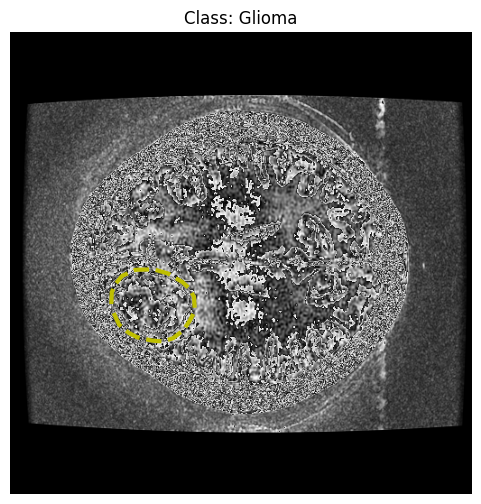

In [9]:
# Plot an image
show_image(images, labels, border_list)

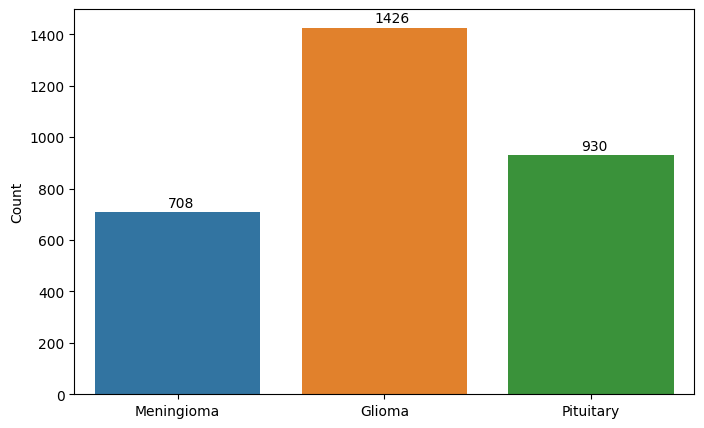

In [11]:
# Repartition of the classes across the dataset
_, counts = np.unique(labels, return_counts=True)

# Plot classes counts
plt.figure(figsize=(8, 5))
sb.barplot(x=list(LABELS_NAME.values()), y=counts)
for i, j in enumerate(counts):
    plt.text(i-0.05, j+20, str(j))
plt.ylabel('Count')
plt.show()

## Preprocessing

In [24]:
# Load the dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE).map(map_image)

# Define train, val, test size
dataset_size = len(images)

train_size = int(TRAIN_SIZE * dataset_size)
val_size = int(VAL_SIZE * dataset_size)
test_size = int(TEST_SIZE * dataset_size)

# Split dataset into train, val and test sets
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

In [34]:
# Check shape of the first 5 batch
for item in train_dataset.take(5):
    print(next(iter(item)).shape)

(128, 512, 512)
(128, 512, 512)
(128, 512, 512)
(128, 512, 512)
(128, 512, 512)


## Modeling